## Task Understanding

Ta sẽ xây dựng mô hình máy học sử dụng mạng CNN để chẩn đoán xem bệnh sốt rét ở người dựa trên thông tin tế bào thu được từ kính hiển vi.

Nhiệm vụ: Cần phân loại chính xác liệu ảnh đầu vào có chứa ký sinh trùng sốt rét hay không?

## Data

Dữ liệu sẽ được lấy trong bộ dữ liệu của [Tensorflow Malaria Dataset](https://www.tensorflow.org/datasets/catalog/malaria)

Ta tiến hành tải dữ liệu

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, InputLayer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

In [93]:
dataset, data_info = tfds.load('malaria', shuffle_files=True, as_supervised=True, with_info=True)

In [94]:
len(dataset['train'])

27558

### Phân chia dữ liệu

In [95]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    train_dataset = dataset.take(int(len(dataset)*TRAIN_RATIO))
    val_dataset = dataset.skip(int(len(dataset)*TRAIN_RATIO))
    val_dataset = val_dataset.take(int(len(dataset)*VAL_RATIO))
    test_dataset = dataset.skip(int(len(dataset)*VAL_RATIO) + int(len(dataset)*TRAIN_RATIO))
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = splits(dataset['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

### Trực quan hóa dữ liệu

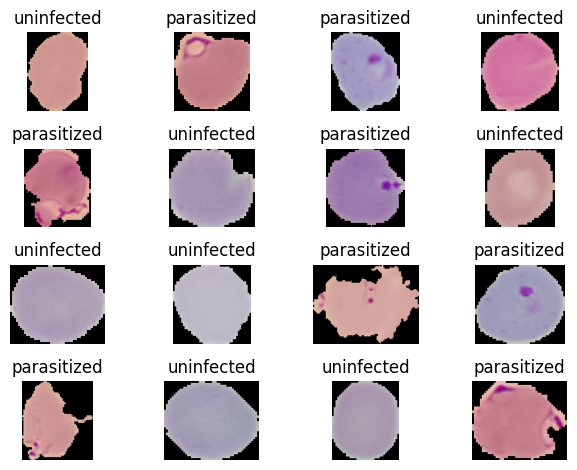

In [96]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(data_info.features['label'].int2str(label.numpy()))
    plt.axis('off')
plt.tight_layout()
plt.show()

## Data Processing

Đầu tiên ta cần đưa mọi hình ảnh về cỡ 224x224, sau đó scale ảnh bằng Min Max Scaler

Cụ thể mỗi pixel chỉ có giá trị lớn nhất là 255 và nhỏ nhất là 0 nên theo công thức

$$
x_{scaled} = \frac{x - x_{max}}{x_{max} - x_{min}}
$$

Thì mỗi pixel ta chỉ cần chia cho 255

In [97]:
IM_SIZE = 224
def resizing_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [98]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [99]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [100]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [101]:
# đây chính là mạng CNN LeNet-5
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),
    # flatten layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.save("baseline_model.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_13 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

Việc thêm lớp `BatchNormalization` vào sau mỗi đầu ra của một layer trong mô hình là để giúp cải thiện hiệu suất và tốc độ huấn luyện của model.

Lợi ích:

- Giảm sự phụ thuộc vào giá trị khởi tạo
- Tăng tốc độ huấn luyện
- Giảm hiện tượng vanishing/exploding gradient
- Tăng độ ổn định và độ chính xác

## Loss Function

Ta sử dụng hàm BinaryCrossEntropy để làm loss function

$$
cost = (-y\log(p) + (1-y)\log(1-p))
$$

Với $p$ là giá trị dự đoán và y là giá trị thực sự

Vậy

$$
Loss = \sum_{i=1}^{M} cost_i
$$

In [102]:
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

## Training Model

In [103]:
history = model.fit(train_dataset, epochs=20, verbose=1, validation_data=val_dataset)

Epoch 1/20
122/689 [====>.........................] - ETA: 25s - loss: 0.5020 - accuracy: 0.7631

KeyboardInterrupt: 

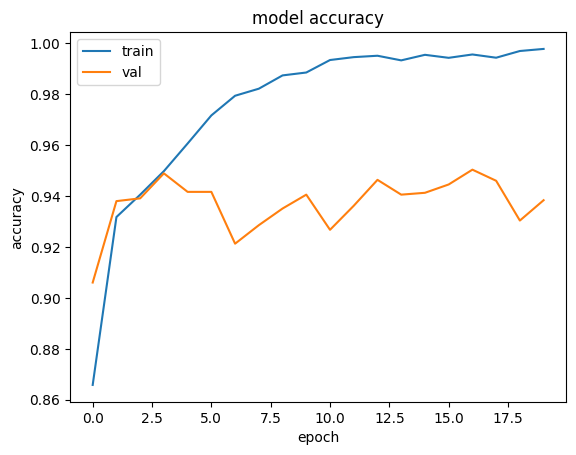

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model Evaluation and Testing

In [ ]:
model.evaluate(test_dataset)

87/87 [==============================] - 4s 21ms/step - loss: 0.3484 - accuracy: 0.9380


[0.3483881950378418, 0.937976062297821]

In [ ]:
model.save('malaria_model.h5')

Ở phần xây dựng model theo cách tuần tự, ta đã xây dựng được mô hình với các lớp nối liền sau nhau. Sẽ ra sao nếu đầu vào là 2 ảnh và có 2 đầu ra?

Ví dụ đầu ra thứ 1 là dự đoán xem liệu có virut kí sinh không, đầu ra thứ 2 là vị trí chính xác mà virut nằm ở đâu trên bức ảnh.

Với Sequential API chúng ta không thể làm được điều này. Vì vậy đó là lí do Functional API quan trọng.

Tiếp theo ta xây dựng Mô Hình ResNet, một mô hình phổ biến trong DeepLearning.


Ví dụ ta có 3 lớp layers, đầu ra của lớp thứ nhất và lớp thứ 2 sẽ là đầu vào của lớp thứ 3, điều này Sequential API không thể làm được.

## Xây dựng một mô hình theo Functional API

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2, padding = 'valid')(x)

x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2, padding = 'valid')(x)


feature_extractor_model = Model(inputs=func_input, outputs=output, name = "Features_Extractor")
feature_extractor_model.summary()


Model: "Features_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 1

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_model(func_input)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(inputs=func_input, outputs=func_output, name = "Lenet_Model")
lenet_model_func.summary()


Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Features_Extractor (Functio  (None, 54, 54, 16)       1136      
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                

In [ ]:
lenet_model_func.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

Vậy ta đã tạo lại được Lenet Model bằng Functional API

## Model Subclassing

In [ ]:
class FeatureExtractor(Layer): # đây là Layer
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size, ):
    # khởi tạo các lớp
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides = 2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides = 2*strides)

  def call(self, x, training=None):
    # nối các lớp lại với nhau
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)

In [ ]:
class LenetModel(Model): # đây là Model
  def __init__(self):
    # khởi tạo các lớp
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training=None):
    # nối các lớp lại với nhau
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)

    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_12 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_13 (Bat  multiple                 

In [ ]:
lenet_sub_classed.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
history = lenet_sub_classed.fit(train_dataset, epochs = 5, verbose= 1)

Epoch 1/20
689/689 [==============================] - 33s 43ms/step - loss: 0.3623 - accuracy: 0.8438
Epoch 2/20
689/689 [==============================] - 31s 45ms/step - loss: 0.2573 - accuracy: 0.9012
Epoch 3/20
689/689 [==============================] - 35s 51ms/step - loss: 0.1915 - accuracy: 0.9293
Epoch 4/20
689/689 [==============================] - 30s 43ms/step - loss: 0.1645 - accuracy: 0.9397
Epoch 5/20
689/689 [==============================] - 30s 44ms/step - loss: 0.1294 - accuracy: 0.9530
Epoch 6/20
689/689 [==============================] - 34s 50ms/step - loss: 0.1417 - accuracy: 0.9479
Epoch 7/20
689/689 [==============================] - 32s 47ms/step - loss: 0.0975 - accuracy: 0.9632
Epoch 8/20
689/689 [==============================] - 42s 61ms/step - loss: 0.0744 - accuracy: 0.9720
Epoch 9/20
689/689 [==============================] - 34s 50ms/step - loss: 0.0559 - accuracy: 0.9804
Epoch 10/20
689/689 [==============================] - 29s 43ms/step - loss: 0.038

## Custom Layer

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.ouput_units = output_units
    self.activation = activation

  def build(self, input_feature_shape):
    # phương thức add_weight có là do kế thừa thừa Layer
    self.w = self.add_weight(shape=(input_feature_shape[-1], self.ouput_units), trainable=True, initializer="random_normal")
    self.b = self.add_weight(shape=(self.ouput_units,), trainable=True, initializer="random_normal")

  def call(self, input_feature, training=None):
    if self.activation == "relu":
      return tf.nn.relu(tf.matmul(input_feature, self.w) + self.b)
    elif self.activation == "sigmoid":
      return tf.nn.sigmoid(tf.matmul(input_feature, self.w) + self.b)
    else:
      return tf.matmul(input_feature, self.w) + self.b


Thử lại với API tuần tự

In [ ]:
lenet_custom = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),
    # flatten layer
    tf.keras.layers.Flatten(),
    NeuralearnDense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    NeuralearnDense(10, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    NeuralearnDense(1, activation='sigmoid')
])

lenet_custom.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_14 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_15 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

In [ ]:
lenet_custom.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

history = lenet_custom.fit(train_dataset, epochs = 5, verbose= 1)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 205s 292ms/step - accuracy: 0.7586 - loss: 0.5025
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 184s 267ms/step - accuracy: 0.9159 - loss: 0.2308
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 206s 298ms/step - accuracy: 0.9259 - loss: 0.2006
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 213s 308ms/step - accuracy: 0.9330 - loss: 0.1763
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 213s 309ms/step - accuracy: 0.9359 - loss: 0.1706


## Model Evaluation

Dựa vào Model đã được đào tạo thì ta có accuracy là gần 94%. Vậy có thể nói rằng 100 người đi khám bệnh sẽ có 6 người bị khám sai. Sẽ ra sao nếu bạn thực sự bị virut nhưng lại bị chẩn đoán là không bị bênh?

Điều này khiến người bị bệnh nhưng bị chẩn đoán sai thiếu đi sự đề phòng và sẽ rất nguy hiểm đến sức khỏe người ấy. Đây là trường hợp False Negative, ta cần tránh điều này xảy ra nhiều nhất có thể nếu không dù Model đạt độ chính xác 94% cũng là vô nghĩa.

Ngược lại, một người thật sự không bị bệnh gì cả bị chẩn đoán là có bệnh, điều này không ảnh hưởng nhiều vì sau khi điều trị và phát hiện ra không có bệnh thì sẽ không có ảnh hưởng cho bệnh nhân đó. Nên trường hợp False Positive có thể được phép xảy ra.

Lấy một ví dụ ta có confusion matrix 

$$
\left[
    \begin{matrix}
    TN & FP\\
    FN & TP\\
    \end{matrix}
\right]
$$

Ta có 2 ma trận của 2 model A và B lần lượt là

$$
cmA = \left[
    \begin{matrix}
    1000 & 700\\
    50 & 1000\\
    \end{matrix}
\right]
;
cmB = \left[
    \begin{matrix}
    1000 & 50\\
    700 & 1000\\
    \end{matrix}
\right]
$$

Cả hai mô hình đều có độ chính xác bằng nhau, nhưng mô hình nào sẽ là mô hình tốt hơn trong bài toán này? Câu trả lời chính là mô hình A vì False Negative thấp.

Lưu ý rằng, không phải là chỉ làm giảm FN và không làm giảm FP. Mà là do chuyện một người bị bệnh bị chẩn đoán sai sẽ tệ hơn rất nhiều so với người khỏe mạnh nhưng chẩn đoán là có bệnh.

Với công thức

$$

\text{Precision} = \frac{TP}{TP+FP};\ \text{Recall} = \frac{TP}{TP+FN}

$$

Thì ta cần tối đa hóa Recall

In [ ]:
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TruePositives, \
    TrueNegatives, Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
metrics = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="precision"),
    Recall(name="recall"),
    AUC(name="auc"),
    TruePositives(name="tp"),
    TrueNegatives(name="tn"),
    FalsePositives(name="fp"),
    FalseNegatives(name="fn")
]

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
history = model.fit(train_dataset, epochs=5, verbose=1, validation_data=val_dataset)

Epoch 1/5


689/689 [==============================] - 46s 63ms/step - loss: 0.1841 - accuracy: 0.9427 - precision: 0.9303 - recall: 0.9571 - auc: 0.9733 - tp: 10551.0000 - tn: 10232.0000 - fp: 790.0000 - fn: 473.0000 - val_loss: 0.2999 - val_accuracy: 0.9292 - val_precision: 0.8864 - val_recall: 0.9848 - val_auc: 0.9631 - val_tp: 1358.0000 - val_tn: 1202.0000 - val_fp: 174.0000 - val_fn: 21.0000
Epoch 2/5
689/689 [==============================] - 38s 54ms/step - loss: 0.1510 - accuracy: 0.9509 - precision: 0.9387 - recall: 0.9649 - auc: 0.9824 - tp: 10637.0000 - tn: 10327.0000 - fp: 695.0000 - fn: 387.0000 - val_loss: 0.3225 - val_accuracy: 0.9154 - val_precision: 0.8686 - val_recall: 0.9813 - val_auc: 0.9678 - val_tp: 1368.0000 - val_tn: 1154.0000 - val_fp: 207.0000 - val_fn: 26.0000
Epoch 3/5
689/689 [==============================] - 39s 56ms/step - loss: 0.1275 - accuracy: 0.9554 - precision: 0.9477 - recall: 0.9640 - auc: 0.9885 - tp: 10628.0000 - tn: 10435.0000 - fp: 586.0000 - fn: 397.000

In [ ]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

Dàn phẳng ra

In [ ]:
labels = np.concatenate(labels)

In [ ]:
inp = np.concatenate(inp)

In [ ]:
predicted = model.predict(inp)

87/87 [==============================] - 2s 13ms/step


### Confusion matrix

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

threshold = 0.25

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

# plt.figure(figsize=(4, 4))
# sns.heatmap(cm, annot=True, fmt="d")
# plt.title("Confusion Matrix")
# plt.ylabel("Actual")
# plt.xlabel("Predicted")
# plt.show()

[[1179  213]
 [  27 1338]]


### Draw ROC Curve

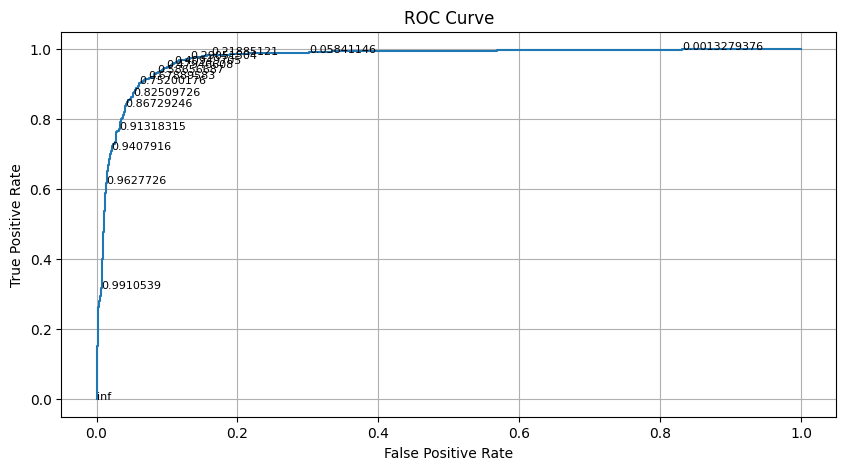

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)

plt.figure(figsize=(10,5))
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

skip = 20

for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i], fontsize=8)

plt.grid()
plt.show()

Thử với threshold là 0.4

In [ ]:
threshold = 0.4

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

[[1234  158]
 [  52 1313]]


## Callbacks

In [ ]:
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [ ]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f"\nEpoch {epoch+1} Loss: {logs['loss']}")
    def on_batch_end(self, batch, logs):
        print(f"\nBatch number {batch + 1} Batch Loss: {logs}")

### CSVLogger

In [ ]:
def retrain(learning_rate, call_back):
    re_model = tf.keras.models.load_model("baseline_model.h5") 
    re_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss = BinaryCrossentropy(),
    metrics=metrics
    )
    history = re_model.fit(train_dataset, epochs=20, verbose=1, validation_data=val_dataset, callbacks=call_back)
    return history

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=",", append=True # nếu append là True thì sẽ ghi thêm vào file logs.csv
)

In [ ]:
retrain(0.001, [csv_callback])

Epoch 1/3
689/689 [==============================] - 38s 50ms/step - loss: 0.0368 - accuracy: 0.9824 - precision: 0.9784 - recall: 0.9866 - auc: 0.9962 - tp: 19097.0000 - tn: 18878.0000 - fp: 422.0000 - fn: 260.0000 - val_loss: 0.2769 - val_accuracy: 0.9343 - val_precision: 0.9362 - val_recall: 0.9329 - val_auc: 0.9690 - val_tp: 1292.0000 - val_tn: 1282.0000 - val_fp: 88.0000 - val_fn: 93.0000
Epoch 2/3
689/689 [==============================] - 38s 55ms/step - loss: 0.0295 - accuracy: 0.9899 - precision: 0.9896 - recall: 0.9903 - auc: 0.9990 - tp: 10916.0000 - tn: 10908.0000 - fp: 115.0000 - fn: 107.0000 - val_loss: 0.2618 - val_accuracy: 0.9140 - val_precision: 0.9551 - val_recall: 0.8707 - val_auc: 0.9728 - val_tp: 1212.0000 - val_tn: 1306.0000 - val_fp: 57.0000 - val_fn: 180.0000
Epoch 3/3
689/689 [==============================] - 45s 66ms/step - loss: 0.0254 - accuracy: 0.9911 - precision: 0.9915 - recall: 0.9907 - auc: 0.9993 - tp: 10924.0000 - tn: 10926.0000 - fp: 94.0000 - fn:

In [ ]:
logs_csv = pd.read_csv('logs.csv')
logs_csv.head()

,epoch,accuracy,auc,fn,fp,loss,precision,recall,tn,tp,val_accuracy,val_auc,val_fn,val_fp,val_loss,val_precision,val_recall,val_tn,val_tp
0,0,0.982358,0.996190,260.0,422.0,0.036842,0.978380,0.986568,18878.0,19097.0,0.934301,0.968992,93.0,88.0,0.276893,0.936232,0.932852,1282.0,1292.0
1,1,0.989930,0.998973,107.0,115.0,0.029487,0.989575,0.990293,10908.0,10916.0,0.913975,0.972805,180.0,57.0,0.261830,0.955083,0.870690,1306.0,1212.0
2,2,0.991109,0.999256,102.0,94.0,0.025398,0.991468,0.990749,10926.0,10924.0,0.944102,0.972192,49.0,105.0,0.270727,0.927486,0.964799,1258.0,1343.0


### Early Stopping

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0, # độ chênh lệch tối thiểu
    patience=3, # sau patience epochs mà không cải thiện thì dừng
    verbose=1, # thông báo khi dừng
    mode='auto', # cách xác định cải thiện, ở đây là auto tức là giảm loss
    baseline=None, # giá trị mà loss phải vượt qua mới được xem là cải thiện
    restore_best_weights=True # khôi phục trọng số tốt nhất
)

In [ ]:
retrain(0.001, [csv_callback, es_callback])

Epoch 1/10
689/689 [==============================] - 40s 56ms/step - loss: 0.0280 - accuracy: 0.9860 - precision: 0.9834 - recall: 0.9888 - auc: 0.9965 - tp: 13289.0000 - tn: 13121.0000 - fp: 224.0000 - fn: 151.0000 - val_loss: 0.2988 - val_accuracy: 0.9281 - val_precision: 0.9599 - val_recall: 0.8950 - val_auc: 0.9726 - val_tp: 1245.0000 - val_tn: 1312.0000 - val_fp: 52.0000 - val_fn: 146.0000
Epoch 2/10
689/689 [==============================] - 37s 53ms/step - loss: 0.0232 - accuracy: 0.9922 - precision: 0.9920 - recall: 0.9923 - auc: 0.9992 - tp: 10941.0000 - tn: 10932.0000 - fp: 88.0000 - fn: 85.0000 - val_loss: 0.2773 - val_accuracy: 0.9419 - val_precision: 0.9315 - val_recall: 0.9544 - val_auc: 0.9719 - val_tp: 1320.0000 - val_tn: 1275.0000 - val_fp: 97.0000 - val_fn: 63.0000
Epoch 3/10
689/689 [==============================] - 34s 50ms/step - loss: 0.0157 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - tp: 10967.0000 - tn: 10967.0000 - fp: 56.0000 - fn

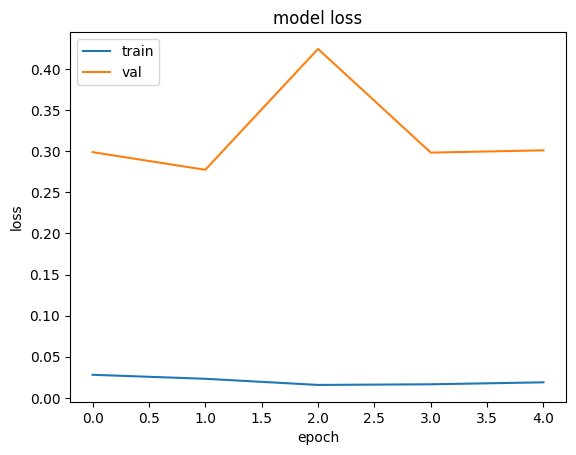

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Learning Rate Scheduler

In [ ]:
def scheduler(epoch, lr):
    if epoch<=3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
retrain(0.001, call_back=[scheduler_callback, es_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
689/689 [==============================] - 42s 58ms/step - loss: 0.3792 - accuracy: 0.8439 - precision: 0.8402 - recall: 0.8507 - auc: 0.9185 - tp: 10340.0000 - tn: 10100.0000 - fp: 1967.0000 - fn: 1815.0000 - val_loss: 0.3599 - val_accuracy: 0.8501 - val_precision: 0.7882 - val_recall: 0.9620 - val_auc: 0.9557 - val_tp: 1340.0000 - val_tn: 1002.0000 - val_fp: 360.0000 - val_fn: 53.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
689/689 [==============================] - 42s 60ms/step - loss: 0.2177 - accuracy: 0.9208 - precision: 0.9115 - recall: 0.9322 - auc: 0.9686 - tp: 10276.0000 - tn: 10025.0000 - fp: 998.0000 - fn: 747.0000 - val_loss: 0.1885 - val_accuracy: 0.9252 - val_precision: 0.9143 - val_recall: 0.9394 - val_auc: 0.9767 - val_tp: 1301.0000 - val_tn: 1248.0000 - val_fp: 122.0000 - val_fn: 84.0000 - lr: 0.0010

Epoch 3: Lear

Có rất nhiều learning scheduler để tham khảo. Như là `TriangularSchedule`, `CosineAnnealingSchedule`, `CyclicalSchedule`.

### Model Checkpoint

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'checkpoints/', monitor='val_loss', verbose=1, 
    save_best_only=True, # save_best_only=True sẽ chỉ lưu model tại val loss bé nhất
    save_weights_only=False, mode='auto', save_freq='epoch',
)

In [ ]:
retrain(0.001, call_back=[scheduler_callback, checkpoint_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
688/689 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8338 - precision: 0.8212 - recall: 0.8540 - auc: 0.9123 - tp: 10596.0000 - tn: 10057.0000 - fp: 2307.0000 - fn: 1811.0000
Epoch 1: val_loss improved from inf to 1.06487, saving model to checkpoints\


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


689/689 [==============================] - 40s 55ms/step - loss: 0.3909 - accuracy: 0.8339 - precision: 0.8213 - recall: 0.8542 - auc: 0.9124 - tp: 10612.0000 - tn: 10069.0000 - fp: 2309.0000 - fn: 1811.0000 - val_loss: 1.0649 - val_accuracy: 0.6784 - val_precision: 0.6102 - val_recall: 0.9935 - val_auc: 0.9187 - val_tp: 1373.0000 - val_tn: 496.0000 - val_fp: 877.0000 - val_fn: 9.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
688/689 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9237 - precision: 0.9121 - recall: 0.9379 - auc: 0.9701 - tp: 10326.0000 - tn: 10011.0000 - fp: 995.0000 - fn: 684.0000
Epoch 2: val_loss improved from 1.06487 to 0.18057, saving model to checkpoints\


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


689/689 [==============================] - 41s 59ms/step - loss: 0.2105 - accuracy: 0.9237 - precision: 0.9120 - recall: 0.9380 - auc: 0.9701 - tp: 10341.0000 - tn: 10023.0000 - fp: 998.0000 - fn: 684.0000 - val_loss: 0.1806 - val_accuracy: 0.9336 - val_precision: 0.9091 - val_recall: 0.9657 - val_auc: 0.9794 - val_tp: 1350.0000 - val_tn: 1222.0000 - val_fp: 135.0000 - val_fn: 48.0000 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
689/689 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9380 - precision: 0.9277 - recall: 0.9500 - auc: 0.9800 - tp: 10474.0000 - tn: 10205.0000 - fp: 816.0000 - fn: 551.0000
Epoch 3: val_loss did not improve from 0.18057
689/689 [==============================] - 39s 56ms/step - loss: 0.1728 - accuracy: 0.9380 - precision: 0.9277 - recall: 0.9500 - auc: 0.9800 - tp: 10474.0000 - tn: 10205.0000 - fp: 816.0000 - fn: 551.0000 - val_loss: 0.2251 - val_accuracy: 0.9249 - val_precisi

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


689/689 [==============================] - 42s 61ms/step - loss: 0.1123 - accuracy: 0.9584 - precision: 0.9545 - recall: 0.9626 - auc: 0.9915 - tp: 10612.0000 - tn: 10516.0000 - fp: 506.0000 - fn: 412.0000 - val_loss: 0.1750 - val_accuracy: 0.9441 - val_precision: 0.9415 - val_recall: 0.9482 - val_auc: 0.9789 - val_tp: 1319.0000 - val_tn: 1282.0000 - val_fp: 82.0000 - val_fn: 72.0000 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/20
689/689 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9717 - precision: 0.9687 - recall: 0.9749 - auc: 0.9959 - tp: 10748.0000 - tn: 10674.0000 - fp: 347.0000 - fn: 277.0000
Epoch 7: val_loss did not improve from 0.17500
689/689 [==============================] - 39s 56ms/step - loss: 0.0773 - accuracy: 0.9717 - precision: 0.9687 - recall: 0.9749 - auc: 0.9959 - tp: 10748.0000 - tn: 10674.0000 - fp: 347.0000 - fn: 277.0000 - val_loss: 0.1956 - val_accuracy: 0.9336 - val_precisio

## Overfitting and Underfitting

### Dropout, Regularization

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L1, L2

In [ ]:
dropout_rate = 0.3
regularization_rate=0.01

model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', 
        activation='relu',kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),
    Dropout(rate = dropout_rate), # thêm dropout layer
 
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', 
        activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),
    # flatten layer
    Flatten(),
    Dense(100, activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),

    Dropout(rate = dropout_rate), # thêm dropout layer
    Dense(10, activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_26 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_27 (Bat  (None, 109, 109, 16)    

## Data Augmentation

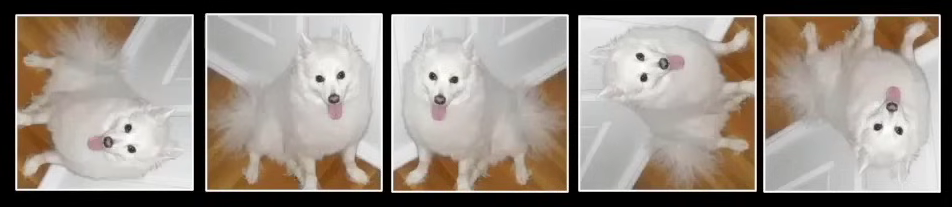

Ta có rất nhiều cách để tạo thêm các dữ liệu cho việc huấn luyện như xoay ảnh, chỉnh sửa độ sáng, phản quang, bão hòa,... hoặc cắt đi một phần của bức ảnh. Với framework Tensorflow image:

- `tf.image.adjust_brightness`: Điều chỉnh độ sáng của hình ảnh.
- `tf.image.adjust_contrast`: Điều chỉnh độ tương phản của hình ảnh.
- `tf.image.adjust_gamma`: Điều chỉnh gamma của hình ảnh.
- `tf.image.adjust_saturation`: Điều chỉnh độ bão hòa màu sắc của hình ảnh.
- `tf.image.flip_left_right`: Lật hình ảnh theo chiều ngang.
- `tf.image.flip_up_down`: Lật hình ảnh theo chiều dọc.
- `tf.image.rot90`: Xoay hình ảnh 90 độ.

Hoặc dùng Tensorflow Keras.

### Phương Pháp Mixup Data

Ta có hai bức ảnh $X_1$ và $X_2$ và 2 nhãn là $y_1$ và $y_2$, ta có thể trộn hai ảnh này để thành một dữ liệu mới với cách trộn như sau. Ta có số $\lambda$ được lấy từ phân phối Beta $(\alpha, \beta)$, với $\alpha, \beta$ thường được lấy bằng 0.2. Từ đó ta có

$$
X_{mixed} = \lambda \times X_1 + (1-\lambda)\times X_2
$$

Và

$$
y_{mixed} = \lambda \times y_1 + (1-\lambda)\times y_2
$$

Tuy nhiên trong bài toán này, các mix này không có tác dụng, thậm chí phản tác dụng.

### Phương pháp CutMix

Với hai bức ảnh $X_1$ và $X_2$, ta cắt một phần của bức ảnh này, và ghi đè vào 1 phần đó của bức ảnh khác.

Tensorflow hỗ trợ phương thức `tf.image.crop_to_bounding_box` để cắt một phần của bức ảnh ra, sau đó dùng `tf.image.pad_to_bounding_box` để tạo ra một bức ảnh như kích thước ban đầu và nó chỉ có 1 phần đã được cắt

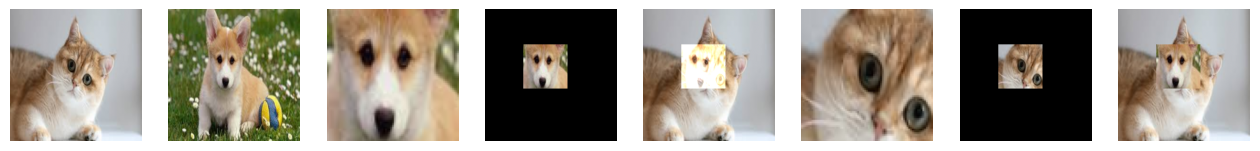

In [ ]:
import cv2
nb = 8

image_1 = cv2.resize(cv2.cvtColor(cv2.imread("cat.png"), cv2.COLOR_BGR2RGB), (IM_SIZE, IM_SIZE))/255.0

image_2 = cv2.resize(cv2.cvtColor(cv2.imread("dog.png"), cv2.COLOR_BGR2RGB), (IM_SIZE, IM_SIZE))/255.0

plt.figure(figsize=(16, 5))
plt.subplot(1, nb, 1)
plt.imshow(image_1)
plt.axis('off')

plt.subplot(1, nb, 2)
plt.imshow(image_2)
plt.axis('off')
# cắt mặt con chó gắn vào con mèo
dog_face = tf.image.crop_to_bounding_box(image_2, target_height=75, target_width=75, offset_height=60, offset_width=65)
plt.subplot(1,nb,3)
plt.imshow(dog_face)
plt.axis('off')
# kích thước ảnh mặt con chó là 75x50

# tạo bức ảnh kích thước ban đầu nhưng chỉ có mặt con chó

crop1 = tf.image.pad_to_bounding_box(dog_face, 60, 65, 224, 224)
plt.subplot(1,nb,4)
plt.imshow(crop1)
plt.axis('off')

# Ta thử dán mặt con chó vào ảnh mèo
plt.subplot(1, nb, 5)
plt.imshow(image_1 + crop1)
plt.axis('off')
# Các giá trị pixel đen được lấp đầy bằng ảnh con mèo, nhưng phần mặt thì không. Nên ta cần cắt bỏ phần của mặt
# mèo trước khi cộng

# cắt phần mặt mèo
cat_face = tf.image.crop_to_bounding_box(image_1, target_height=75, target_width=75, offset_height=60, offset_width=65)
plt.subplot(1, nb, 6)
plt.imshow(cat_face)
plt.axis('off')
# tạo bức ảnh kích thước ban đầu nhưng chỉ có mặt mèo
crop2 = tf.image.pad_to_bounding_box(cat_face, 60, 65, 224, 224)

plt.subplot(1, nb, 7)
plt.imshow(crop2)
plt.axis('off')
# mixcut
mixcut = image_1 - crop2 + crop1
plt.subplot(1, nb, 8)
plt.imshow(mixcut)
plt.axis('off')

plt.show()

Thông thường khi mixcut, ta có thể chọn phần ảnh bị cắt ra như sau:

$$
\begin{align*}
r_x \sim \text{Uniform(0, $W$)};\  r_w = W\sqrt{1-\lambda}\\
r_y \sim \text{Uniform(0, $H$)};\  r_h = H\sqrt{1-\lambda}
\end{align*}
$$

Trong đó $r_x, r_y$ là tọa độ trung tâm của "hộp" được cắt ra. Và từ đó ta có được tỉ lệ khu vực được cắt
$$
\frac{r_w r_h}{WH} = 1 - \lambda
$$

Nhưng phương thức của tensorflow thì lại có tọa độ cắt là góc trên cùng bên trái, nên ta cần chuyển $r_x, r_y$ từ tọa độ trung tâm hộp thành tọa độ góc trên cùng bên trái:

$$
r_x = r_x - \frac{r_W}{2};\ r_y = r_y - \frac{r_H}{2}
$$

Chúng ta sẽ gặp một vấn đề là, nếu tọa độ trung tâm rất gần rìa bức ảnh, và kích thước hộp lớn dẫn đến việc các tạo độ có thể bị âm. Nên ta cần xử lý lại tọa độ bằng cách không cho nó nhỏ hơn 0 và không lớn hơn kích thước ảnh. 

Sau khi có tọa độ góc trên cùng bên phải, ta cần tìm ra tọa độ góc dưới cùng bên phải để tính toán lại chiều rộng và chiều cao của bức hình.

$$
r_x' = r_x + r_W;\ r_y' = r_y + r_Y
$$

Từ đó có

$$
W' = r_x' - r_x;\ H' = r_y' - r_y
$$

Xong ta tính toán lại $\displaystyle \lambda = 1 - \frac{r_w r_h}{WH}$ sau đó ta có label mới là 
$$
y_{cutmix} = \lambda \times y_1 + (1-\lambda) \times y_2
$$

## Advance Topics

### Custom loss and metrics

#### Custom Loss Method (without Parameters)

In [ ]:
def custom_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)

#### Custom Loss Method (with Parameters)

In [ ]:
FACTOR = 1
def custom_bce_factor(FACTOR):
    def loss(y_true, y_pred):
        bce = BinarryCrossentropy()
        return bce(y_true, y_pred) * FACTOR 
    return loss

#### Custom Loss Class

In [ ]:
class CustomBCE(tf.keras.losses.Loss):
    def __init__(seft, FACTOR):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR
    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * self.FACTOR

#### Custom Metric Method (without parameters)

In [ ]:
def custom_accuracy(y_true, y_pred):
    acc = BinaryAccuracy()
    return acc(y_true, y_pred)

#### Custom Metric Method (with parameters)

In [ ]:
FACTOR
def custom_bce_factor(FACTOR):
    def metric(y_true, y_pred):
        return BinaryAccuracy(y_true, y_pred) * FACTOR 
    return metric

#### Custom Metric Class

In [ ]:
class CustomACC(tf.keras.metrics.Metric):
    def __init__(seft, name="Custom Accuracy", FACTOR=1):
        super(CustomACC, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name=name, initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        output = BinaryAccuracy(y_true, y_pred) * self.FACTOR
        self.accuracy.assign(tf.math.count_nonzero(output) / tf.size(output))

    def result(self):
        return self.accuracy

    def reset_states(self):
        self.accuracy.assign(0.0)

## Data Logging

In [ ]:
# tensorboard callback
LOG_DIR = "logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)
model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[tensorboard_callback])

Epoch 1/5
689/689 [==============================] - 41s 56ms/step - loss: 0.3247 - accuracy: 0.8629 - val_loss: 0.2399 - val_accuracy: 0.9292
Epoch 2/5
689/689 [==============================] - 33s 47ms/step - loss: 0.1797 - accuracy: 0.9428 - val_loss: 0.3340 - val_accuracy: 0.9180
Epoch 3/5
689/689 [==============================] - 46s 67ms/step - loss: 0.1586 - accuracy: 0.9507 - val_loss: 0.1853 - val_accuracy: 0.9452
Epoch 4/5
689/689 [==============================] - 39s 56ms/step - loss: 0.1443 - accuracy: 0.9530 - val_loss: 0.1670 - val_accuracy: 0.9485
Epoch 5/5
689/689 [==============================] - 48s 69ms/step - loss: 0.1329 - accuracy: 0.9570 - val_loss: 0.3081 - val_accuracy: 0.9466


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
tensorboard --logdir='logs/'

## Fine Tuning Hyperarameters

In [104]:
IM_SIZE = 224
def model_tune(hparams):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),
    
    Dense( hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),
    
    Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  lenet_model.fit(val_dataset, epochs=1)
  _, accuracy = lenet_model.evaluate(val_dataset)
  return accuracy

In [105]:
from tensorboard.plugins.hparams import api as hp

In [106]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              HP_REGULARIZATION_RATE: regularization_rate,
              HP_LEARNING_RATE: learning_rate,
              
          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1